# Hacking generator

We will try to hack the network given generator and leaked train data. We will consider leakages to be equal to 20% of the all dataset.

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd

In [2]:
import os

GDRIVE_PATH = '/data/apsidorenko'
THIS_EXERCISE_PATH = os.path.join(GDRIVE_PATH, "GAN_exercises")
MODELS_HOME = os.path.join(THIS_EXERCISE_PATH, "mnist guns")

In [3]:
os.makedirs(THIS_EXERCISE_PATH, exist_ok=True)
os.makedirs(MODELS_HOME, exist_ok=True)

In [4]:
df = pd.read_csv('https://query.data.world/s/nap7jvxtupud25z5ljvtbzzjjsqqay')
df.head()

,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,...,column_774,column_775,column_776,column_777,column_778,column_779,column_780,column_781,column_782,column_783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
target = pd.read_csv('https://query.data.world/s/sn3dximsq5sw3a6wtqoc3okulevugz')
target.head()

,column_0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [6]:
from sklearn.model_selection import train_test_split
train, test, tar_train, tar_test = train_test_split(df, target, test_size=0.2, random_state=12345)

In [7]:
train = np.array(train, dtype='float')
test = np.array(test, dtype='float')
tar_train = np.array(tar_train, dtype='float')
tar_test = np.array(tar_test, dtype='float')

In [8]:
train= train.reshape((-1, 1, 28, 28)) / 255.
test= test.reshape((-1, 1, 28, 28)) / 255.

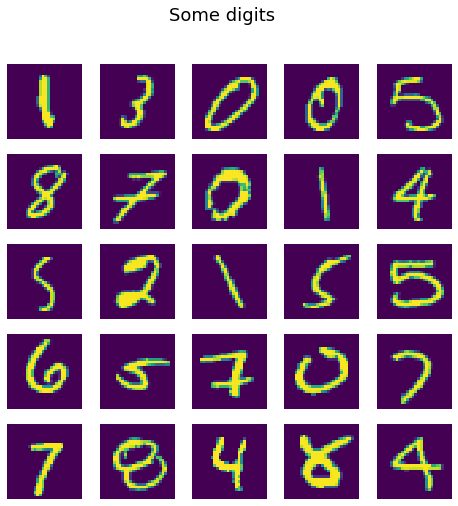

In [9]:
def plot_images(images: np.ndarray,
                nrows: int=5, ncols: int=5,
                shuffle: bool=True,
                title: str="",
                figure: matplotlib.figure.Figure=None) -> matplotlib.figure.Figure:
  """
  Plots a subset of images.
  
  Args:
    images[n_images, n_channels, width, height]: a dataset with images to plot
    nrows: number of images in a plotted row
    ncols: numer of images in a plotted colunm
    shuffle: if True draw a random subset of images, if False -- the first ones
    figure: if not None, it's used for plotting, if None, a new one is created
  
  Returns:
    a figure containing the plotted images
  """
  if shuffle:
    images_to_plot = images[np.random.permutation(len(images))[:nrows*ncols]]
  else:
    images_to_plot = images[:nrows * ncols]
  h, w = images_to_plot.shape[2:]
  if figure is None:
    figure = plt.figure(figsize=(8,8))
  
  axes = figure.subplots(nrows=nrows, ncols=ncols)
  for row_idx, ax_row in enumerate(axes):
    for col_idx, ax in enumerate(ax_row):
      ax.imshow(images_to_plot[row_idx + ncols*col_idx, 0],
                interpolation="none")
      ax.set_axis_off()

  figure.suptitle(title, fontsize=18)
  return figure

plot_images(train, title="Some digits");

# Building GAN

In [10]:
import torch
from torch import nn
from torch.nn.functional import logsigmoid

class Reshape(torch.nn.Module):
  """
  Reshapes a tensor starting from the 1st dimension (not 0th),
  i. e. without influencing the batch dimension.
  """
  def __init__(self, *shape):
    super(Reshape, self).__init__()
    self.shape = shape

  def forward(self, x):
    return x.view(x.shape[0], *self.shape)
  
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.shape[0], -1)

In [11]:
GENERATOR_FILE = os.path.join(MODELS_HOME, 'generator_other.pt')
DISCRIMINATOR_FILE = os.path.join(MODELS_HOME, 'discriminator_bamboo.pt')

In [12]:
CODE_SIZE = 256
DROPOUT_RATE = 0.1

try:
  generator = torch.load(GENERATOR_FILE)
  #discriminator = torch.load(DISCRIMINATOR_FILE)
except FileNotFoundError:
 print('FUUUUUU!')


In [13]:
def sample_fake(batch_size):
  noise = torch.randn(batch_size, CODE_SIZE, device="cuda")
  return generator(noise)

In [14]:
# A small check that the generator output has the right size
test_generated_data = sample_fake(1)
assert tuple(test_generated_data.shape[1:]) == train.shape[1:]

In [15]:
def sample_images(batch_size, train=train):
  ids = np.random.choice(len(train), size=batch_size)
  return torch.tensor(train[ids], device="cuda").float()

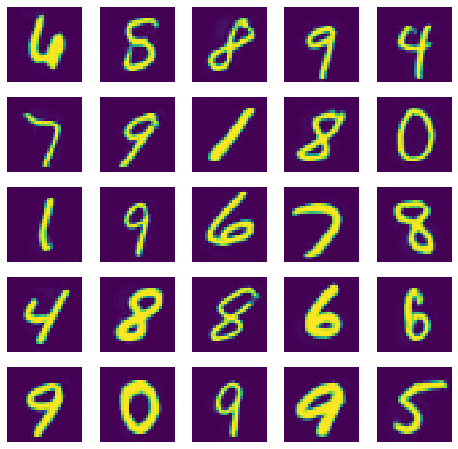

In [16]:
generator.eval()
imgs = sample_fake(25).cpu().detach().numpy()
plot_images(imgs.clip(0, 1));

Now suppose we have no discriminator, but we have some part of the train set

In [17]:
np.random.seed(123456)

In [18]:
n_leak = round(train.shape[0] * 0.2)

In [19]:
train_leak = train[np.random.permutation(train.shape[0])]
train_check = train_leak[n_leak:]
train_leak = train_leak[0:n_leak]

In [20]:
train_leak.shape

(11200, 1, 28, 28)

In [21]:
discriminator = nn.Sequential(
           #Reshape(1, 28,28),
           torch.nn.Conv2d(1, 8, kernel_size=3, padding=1),
           torch.nn.ELU(),
           torch.nn.Dropout(p=DROPOUT_RATE),
      
            torch.nn.MaxPool2d(2), # 18x18
      
            torch.nn.Conv2d(8, 32, kernel_size=3, padding=1),
            torch.nn.ELU(),
            torch.nn.Dropout(p=DROPOUT_RATE),
      
            torch.nn.MaxPool2d(2), # 9x9
      
            torch.nn.Conv2d(32, 64, kernel_size=3), # 7x7
            torch.nn.ELU(),
            torch.nn.Dropout(p=DROPOUT_RATE),
      
            torch.nn.Conv2d(64, 256, kernel_size=3), # 5x5
            torch.nn.ELU(),
            torch.nn.Dropout(p=DROPOUT_RATE),
      
            torch.nn.Conv2d(256, 512, kernel_size=3), # 3x3
            torch.nn.ELU(),
            torch.nn.Dropout(p=DROPOUT_RATE),
      
             Reshape(512),
             torch.nn.Linear(512, 1)
).cuda()

In [22]:
noise_power = 0.1
gradient_penalty = 0.0001


  
def discriminator_loss(real, fake):
  return -logsigmoid(discriminator(
              real + torch.randn(*real.shape, device="cuda") * noise_power
          )).mean() - \
          logsigmoid(-discriminator(
              fake + torch.randn(*fake.shape, device="cuda") * noise_power
          )).mean()

def discriminator_penalty(real, size=gradient_penalty):
  scores = discriminator(real)
  grad_params = torch.autograd.grad(scores.mean(), discriminator.parameters(),
                                    create_graph=True)
  penalty = sum((grad**2).sum() for grad in grad_params)
  return penalty * size

In [23]:
optimizer_discriminator = \
    torch.optim.RMSprop(discriminator.parameters(), lr=0.001)

disc_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_discriminator, step_size=10, gamma=0.999)

In [24]:
VALIDATION_INTERVAL = 150
SAVE_INTERVAL = 500
#DISCRIMINATOR_ITERATIONS_PER_GENEREATOR = 5
BATCH_SIZE=128

In [25]:
losses = np.zeros(10000)

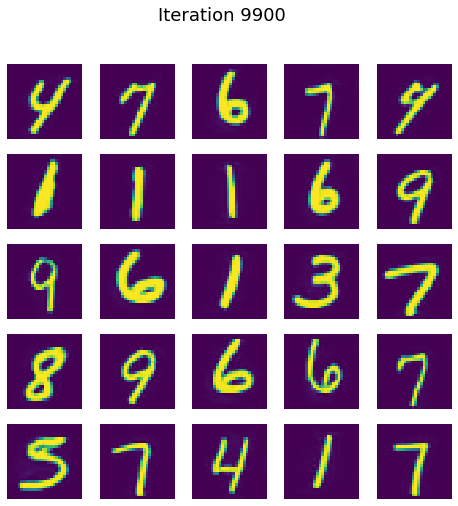

In [26]:
from IPython.display import clear_output
for i in range(10000):
  # Set our models to training mode:
    discriminator.train()
    disc_scheduler.step()
  
    # Sampling reals and fakes
    real = sample_images(BATCH_SIZE, train_leak)
    fake = sample_fake(BATCH_SIZE)
    
    # Calculating the loss
    discriminator_loss_this_iter = discriminator_loss(real, fake) + \
                                   discriminator_penalty(real)
    
    # Doing our regular optimization step for the discriminator
    optimizer_discriminator.zero_grad()
    discriminator_loss_this_iter.backward()
    optimizer_discriminator.step()
    
    losses[i] = discriminator_loss_this_iter

    if i % SAVE_INTERVAL == 0:
        torch.save(generator, GENERATOR_FILE)
        torch.save(discriminator, DISCRIMINATOR_FILE)
    
    if i % VALIDATION_INTERVAL == 0:
        clear_output(wait=True)
        generator.eval()
        imgs = sample_fake(25).cpu().detach().numpy()
        plot_images(imgs.clip(0, 1), title='Iteration '+str(i));
        plt.show();

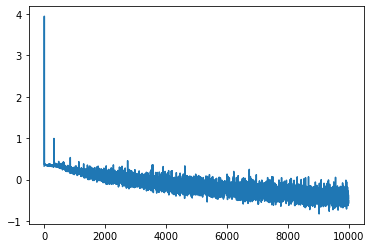

In [39]:
plt.plot(np.log(losses))

# Making a test

In [28]:
test_leak = np.concatenate((train_check[np.random.permutation(train_check.shape[0])][0:1000], 
                            sample_fake(1000).cpu().detach().numpy()), axis=0)

In [29]:
ans = discriminator(torch.tensor(test_leak).float().cuda()).cpu().detach().numpy().reshape(-1)

In [30]:
labels = np.array([x < 1000 for x in range(2000)], dtype=int)

In [31]:
df = pd.DataFrame({'ans':ans, 'label':labels})

In [32]:
df.head()

,ans,label
0,0.070804,1
1,-0.463140,1
2,-0.603295,1
3,-0.067865,1
4,-0.722302,1


In [37]:
recall = df.sort_values(by='ans', ascending=False).iloc[0:1000]['label'].sum() / 1000

In [38]:
print("The recall of the model is: ", recall)

The recall of the model is:  0.635


In [36]:
df['label'].sum()

1000

We have managed to make this attack! BINGO!